### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [2]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 9)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4


In [3]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [4]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DAY'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE
0,2029.0,2011,1,1
1,3084.0,2011,1,2
2,2776.0,2011,1,3
3,2311.0,2011,1,4
4,1847.0,2011,1,5


In [5]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [6]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())

In [7]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 4), (330, 4))

In [12]:
def prepare_dataset(df):
    data = []
    for idx, row in df.iterrows():
        inflow = row['INFLOW_CUSECS']
        year = row['YEAR']
        month = row['MONTH']
        date = row['DATE']
        
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        data.append([month, date, season, prev_avg_rainfall, prev_avg_departure, inflow])
    
    return pd.DataFrame(data, columns=['MONTH', 'DATE', 'SEASON', 'PREV_AVG_RAINFALL', 'PREV_AVG_DEPARTURE', 'INFLOW'])

In [14]:
train_df = prepare_dataset(train_inflow_df)
test_df = prepare_dataset(val_inflow_df)

In [15]:
train_df.head()

,MONTH,DATE,SEASON,PREV_AVG_RAINFALL,PREV_AVG_DEPARTURE,INFLOW
0,1.0,1.0,WINTER,4.133333,-4.0,2029.0
1,1.0,2.0,WINTER,4.133333,-4.0,3084.0
2,1.0,3.0,WINTER,4.133333,-4.0,2776.0
3,1.0,4.0,WINTER,4.133333,-4.0,2311.0
4,1.0,5.0,WINTER,4.133333,-4.0,1847.0


### Model

In [124]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=8)
        self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=8)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=8)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=8),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_features=8*4, out_features=48),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=48, out_features=48),
            nn.LeakyReLU(),
            nn.Linear(in_features=48, out_features=16),
            nn.LeakyReLU(),
        )
        self.rainfall_layer = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=16),
            nn.Linear(in_features=16, out_features=8),
            nn.LeakyReLU(),
            nn.Linear(in_features=8, out_features=1),
            nn.ReLU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=16),
            nn.Linear(in_features=16, out_features=8),
            nn.LeakyReLU(),
            nn.Linear(in_features=8, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_date, x_season, x_prev_data):
        month_out = self.month_emb(x_month)
        date_out = self.date_emb(x_date)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        x = torch.cat([month_out, date_out, season_out, prev_data_out], axis=1)
        hidden_out = self.hidden_layer(x)
        rainfall_out = self.rainfall_layer(hidden_out)
        inflow_out = self.inflow_layer(hidden_out)

        return rainfall_out, inflow_out
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)

### Training

In [125]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    mean_inflow = train_inflow_df['INFLOW_CUSECS'].mean()
    mean_rainfall = rainfall_departure_df['RAINFALL'].mean()
    inflow_loss_weight = int((mean_inflow + mean_rainfall) / mean_inflow)
    rainfall_loss_weight = int((mean_inflow + mean_rainfall) / mean_rainfall)
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_date = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            y_inflow = yb[0].cuda()
            y_rainfall = yb[1].cuda()

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]
            loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_date = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                y_inflow = yb[0].cuda()
                y_rainfall = yb[1].cuda()

                y_hat = model(x_month, x_date, x_season, x_prev_data)
                y_hat_rainfall = y_hat[0]
                y_hat_inflow = y_hat[1]
                loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [126]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [127]:
train(model, epochs=1000, lr=1e-02)

Epoch - 1 | LR - 0.01 | Train Loss - 64047556.42 | Val Loss - 33801183.78
Epoch - 2 | LR - 0.01 | Train Loss - 54438901.09 | Val Loss - 23974892.47
Epoch - 3 | LR - 0.01 | Train Loss - 37483126.92 | Val Loss - 14902853.34
Epoch - 4 | LR - 0.01 | Train Loss - 31880501.39 | Val Loss - 14787508.33
Epoch - 5 | LR - 0.01 | Train Loss - 31160625.09 | Val Loss - 14843250.24
Epoch - 6 | LR - 0.01 | Train Loss - 30863522.62 | Val Loss - 15226341.74
Epoch - 7 | LR - 0.01 | Train Loss - 31153414.66 | Val Loss - 15773357.88
Epoch - 8 | LR - 0.01 | Train Loss - 30725513.48 | Val Loss - 15661053.99
Epoch - 9 | LR - 0.01 | Train Loss - 30929908.84 | Val Loss - 15584780.84
Epoch - 10 | LR - 0.01 | Train Loss - 30568648.67 | Val Loss - 16241937.91
Epoch - 11 | LR - 0.01 | Train Loss - 30260223.47 | Val Loss - 17451503.48
Epoch - 12 | LR - 0.01 | Train Loss - 30159749.06 | Val Loss - 15573923.01
Epoch - 13 | LR - 0.01 | Train Loss - 30056188.79 | Val Loss - 16903179.0
Epoch - 14 | LR - 0.01 | Train Loss

Epoch - 108 | LR - 1.0000000000000002e-06 | Train Loss - 28306874.68 | Val Loss - 21740248.73
Epoch - 109 | LR - 1.0000000000000002e-06 | Train Loss - 29070011.54 | Val Loss - 19837369.43


### Prediction on Validation Dataset

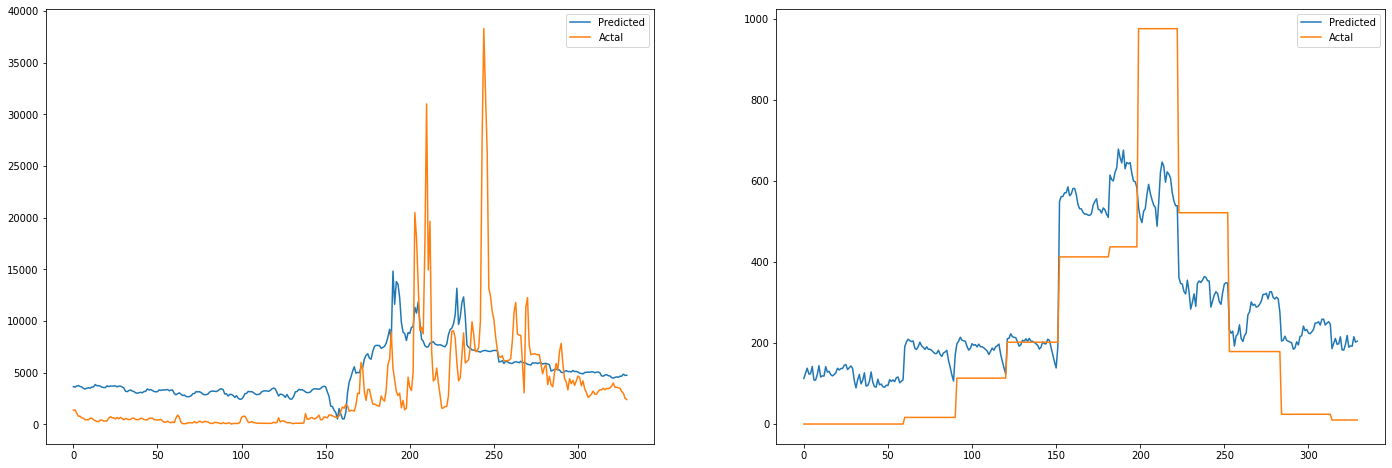

In [128]:
y_actual_rainfall, y_pred_rainfall = [], []
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_date = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        y_inflow = yb[0]
        y_rainfall = yb[1]

        y_hat = model(x_month, x_date, x_season, x_prev_data)
        y_hat_rainfall = y_hat[0]
        y_hat_inflow = y_hat[1]

        y_actual_rainfall += y_rainfall.data.tolist()
        y_actual_inflow += y_inflow.data.tolist()
        y_pred_rainfall += y_hat_rainfall.cpu().data.tolist()
        y_pred_inflow += y_hat_inflow.cpu().data.tolist()

y_actual_rainfall = np.array(y_actual_rainfall).flatten()
y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_rainfall = np.array(y_pred_rainfall).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
ax1.plot(y_pred_inflow, label='Predicted')
ax1.plot(y_actual_inflow, label='Actal')
ax1.legend()
ax2.plot(y_pred_rainfall, label='Predicted')
ax2.plot(y_actual_rainfall, label='Actal')
ax2.legend()
plt.show()

### Prediction on entire Dataset

In [109]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_date = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y_inflow = yb[0]
            y_rainfall = yb[1]

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]

    return y_hat_inflow.data.cpu().view(-1).tolist(), y_hat_rainfall.data.cpu().view(-1).tolist()

In [110]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DATE']).copy()
model_test_df['Predicted_Inflow'], model_test_df['Predicted_Rainfall'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DATE,Predicted_Inflow,Predicted_Rainfall
0,2029.0,2011,1,1,1325.077271,228.020157
31,1987.0,2011,2,1,621.457520,234.662643
59,635.0,2011,3,1,365.002350,209.813904
90,587.0,2011,4,1,394.654144,235.232590
120,1719.0,2011,5,1,541.100525,255.301575
151,1306.0,2011,6,1,2239.781250,524.087769
181,7601.0,2011,7,1,7422.083984,658.505798
212,8588.0,2011,8,1,9047.092773,628.098572
243,18132.0,2011,9,1,9437.689453,372.760071
273,2668.0,2011,10,1,6195.731445,227.647156


In [111]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values
avg_daily_pred_rainfall = model_test_df.groupby(['MONTH'])['Predicted_Rainfall'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

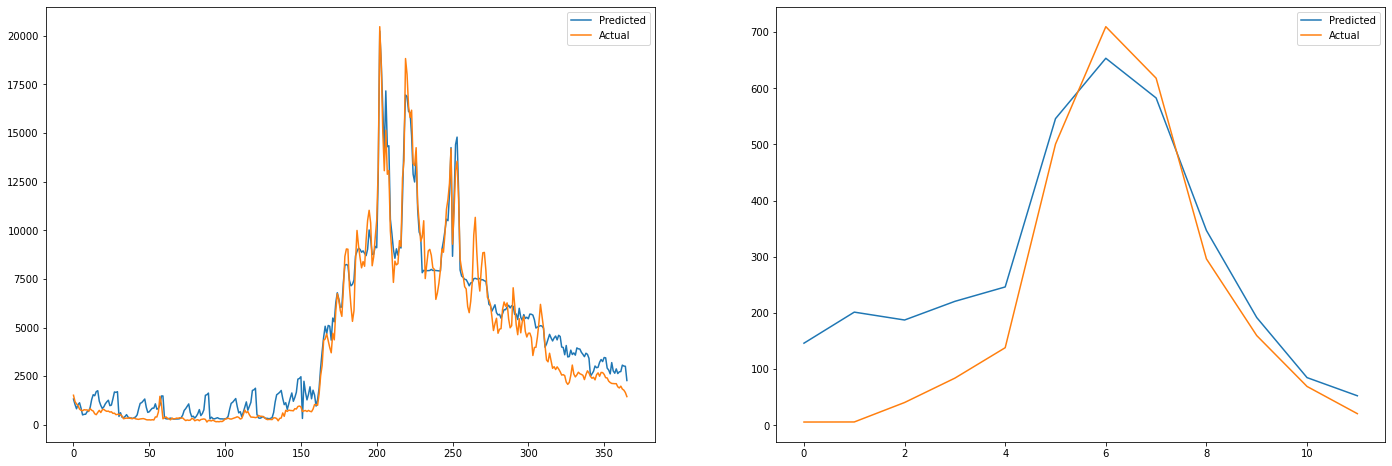

In [112]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.plot(avg_daily_pred_inflow, label='Predicted')
ax1.plot(avg_daily_actual_inflow, label='Actual')
ax1.legend()
ax2.plot(avg_daily_pred_rainfall, label='Predicted')
ax2.plot(avg_daily_actual_rainfall, label='Actual')
ax2.legend()
plt.show()

In [113]:
model_test_df['Predicted_Rainfall'].describe()

count    3274.000000
mean      290.733512
std       198.909051
min        37.764549
25%       152.324097
50%       221.857895
75%       485.199768
max       701.371704
Name: Predicted_Rainfall, dtype: float64

In [114]:
rainfall_departure_df['RAINFALL'].describe()

count     156.000000
mean      220.685897
std       287.744814
min         0.000000
25%        13.800000
50%       103.800000
75%       314.500000
max      1318.100000
Name: RAINFALL, dtype: float64

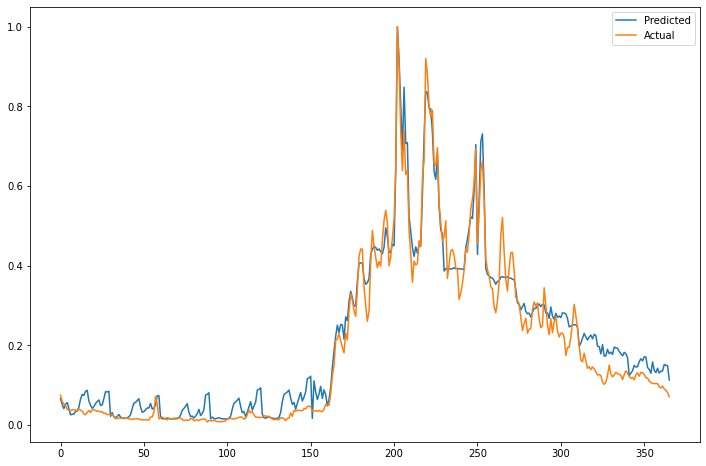

In [115]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')

plt.legend()
plt.show()

In [116]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

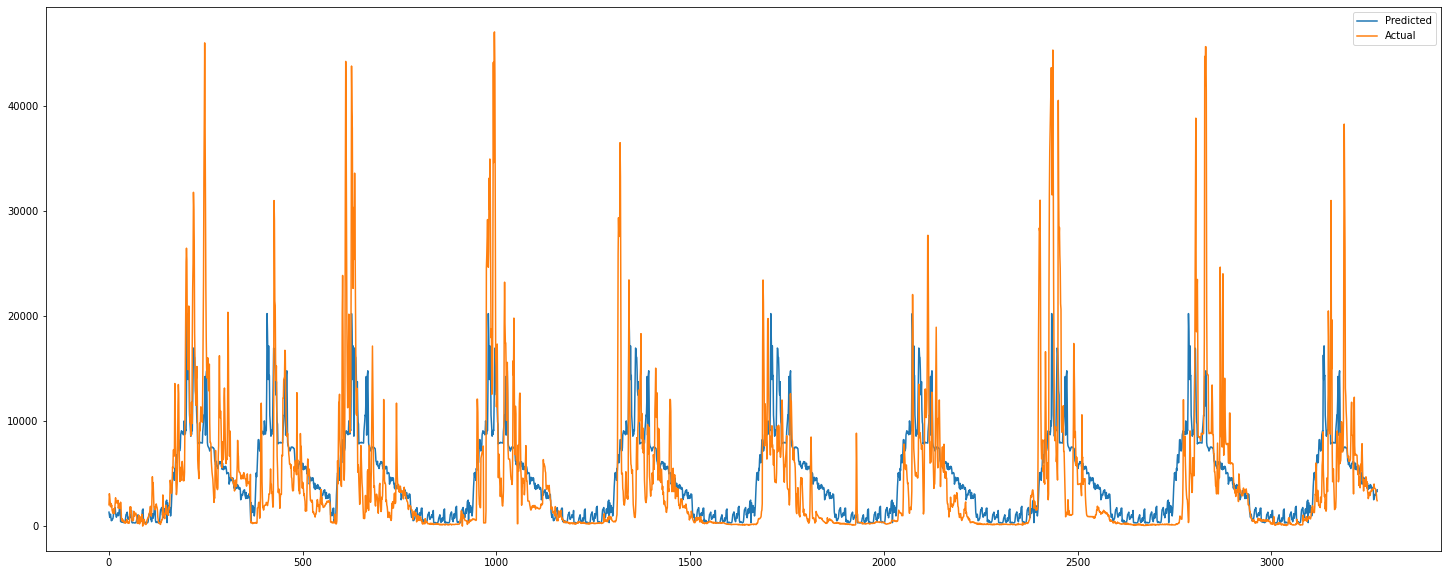

In [117]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [118]:
pred_rainfall_df = model_test_df[['YEAR', 'MONTH', 'Predicted_Rainfall']].groupby(['YEAR', 'MONTH']).mean().reset_index()
rainfall_with_pred_df = rainfall_departure_df.merge(pred_rainfall_df, on=['YEAR', 'MONTH'])
rainfall_with_pred_df = rainfall_with_pred_df.sort_values(by=['YEAR', 'MONTH']).reset_index()
rainfall_with_pred_df

,index,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON,Predicted_Rainfall
0,0,KODAGU,0.7,2011.0,1.0,-80.0,WINTER,148.661739
1,10,KODAGU,22.2,2011.0,2.0,429.0,WINTER,201.702535
2,19,KODAGU,13.2,2011.0,3.0,-29.0,SUMMER,187.510773
3,27,KODAGU,138.5,2011.0,4.0,54.0,SUMMER,220.655194
4,35,KODAGU,107.5,2011.0,5.0,-30.0,SUMMER,246.499910
...,...,...,...,...,...,...,...,...
109,73,KODAGU,974.9,2020.0,8.0,66.0,MONSOON,587.229806
110,83,KODAGU,521.1,2020.0,9.0,126.0,MONSOON,346.758266
111,93,KODAGU,178.7,2020.0,10.0,-14.0,WINTER,191.665830
112,103,KODAGU,24.1,2020.0,11.0,-69.0,WINTER,84.847021


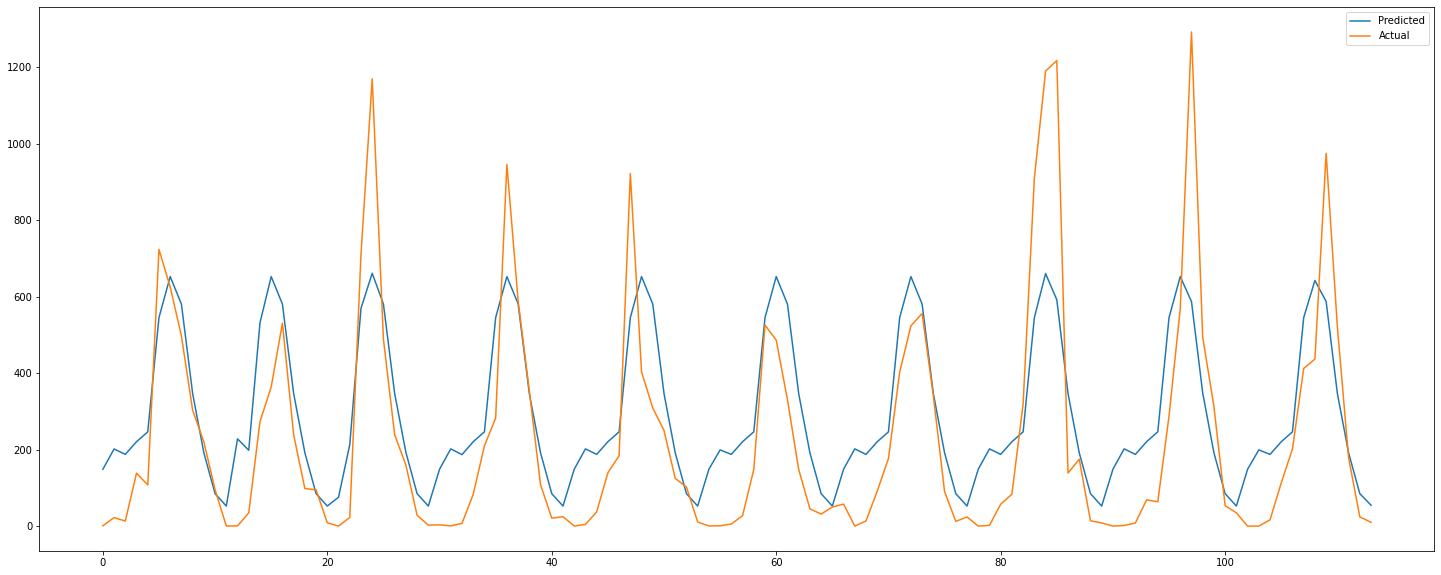

In [119]:
plt.figure(figsize=(25, 10))
plt.plot(rainfall_with_pred_df['Predicted_Rainfall'], label='Predicted')
plt.plot(rainfall_with_pred_df['RAINFALL'], label='Actual')
plt.legend()
plt.show()

In [120]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 6), (330, 6))

In [121]:
train_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] < 2020]
val_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] == 2020]
train_rainfall_with_pred.shape, val_rainfall_with_pred.shape

((102, 8), (12, 8))

In [122]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((train_rainfall_with_pred['RAINFALL'] - train_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

5325.235720698413

In [123]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((val_rainfall_with_pred['RAINFALL'] - val_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

4308.31469955114

In [ ]:
# torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')